### **Analyse-des-facteur-discriminant-les-patients-diabetiques-des-nons-diabetiques-en-utilisant-l'analyse-factorielle-discriminante (AFD)**

## **Contexte**

Dans ce cas concret, nous appliquons l’analyse factorielle discriminante (AFD) à un jeu
de données réel extrait du fichier diabetes.csv. Ce jeu de données est largement utilisé
dans le domaine médical pour étudier le diabète. Il contient plusieurs variables quantita-
tives telles que la glycémie, l’indice de masse corporelle (IMC), la pression artérielle, ainsi
que d’autres paramètres biologiques.
Les observations représentent des patients, et une variable qualitative indique l’appar-
tenance à l’une des classes suivantes :

**Diabétique** et **Non-diabétique**
####
L’objectif est de comprendre quelles variables discriminent le mieux les patients dia-
bétiques des non-diabétiques et de visualiser cette séparation dans un espace réduit.

### **Importation des bibliotheques**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Classe implementant toutes les fonctionnalites du projet

In [7]:
class DiscriminantAnalyser:
    def __init__(self, filepath=None, colonneCible=None):
        """
            Initialisation de l'analyseur discriminant
        
            Parameters:
            -----------
            filepath : str, optional
            Chemin vers le fichier de données CSV
        """
        self.data = None
        self.X = None
        self.y = None
        self.feature_names = None
        self.scaler = StandardScaler()
        self.lda = None
        self.colonne_cible = colonneCible
        
        #=======( Chargeons les données si un chemin est fourni )======
        if filepath:
            self.load_data(filepath)
            
        # #=======( definisons  la colonne cible si elle est definit )======
        # if colonneCible:
        #     self.colonne_cible = colonneCible
    
    # ===( Fonction nous permettant de charger les donnees )===
    def load_data(self, filepath):
        """
            Charger les données à partir d'un fichier CSV
        
            Parameters:
        -----------
            filepath : str
            Chemin vers le fichier de données
        """
        #===( Charger le dataset )==
        self.data = pd.read_csv(filepath)
        
        #==( Identifions la colonne cible )==
        target_column = self.colonne_cible
        
        #==( Séparation features et target )==
        self.X = self.data.drop(target_column, axis=1)
        self.y = self.data[target_column]
        self.feature_names = self.X.columns.tolist()
        
        
        print("Colonnes du dataset:", self.feature_names)
        print("\nDistribution des classes:")
        print(self.y.value_counts(normalize=True))
    
    # ====( Fonction nous permettant de preparer les donnees )====
    def prepare_data(self, test_size=0.3, random_state=42):
        """
            Préparer les données pour l'analyse discriminante
        
        Parameters:
        -----------
            test_size : float, optional
                Proportion de données de test
            random_state : int, optional
                Graine pour la reproductibilité
        
        Returns:
        --------
        tuple : Données d'entraînement et de test
        """
        # ===( Standardisons les  données )===
        X_scaled = self.scaler.fit_transform(self.X)
        
        #===( Sépararons les donnees en train/test )==
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y, 
            test_size=test_size, 
            random_state=random_state
        )
        
        return X_train, X_test, y_train, y_test
    
    # ==( Fonction permettant de realiser l'analyse factorielle discriminante )==
    def perform_lda(self, n_components=None):
        """
            Réaliser l'Analyse Discriminante Linéaire
        
        Parameters:
        -----------
            n_components : int, optional
             Nombre de composantes à conserver
        
        Returns:
        --------
            array : Données projetées
        """
        # ==( Préparons les données )==
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        #==( Déterminons le nombre de composantes si elle n'a pas ete definit )==
        if n_components is None:
            n_classes = len(np.unique(self.y))
            n_features = self.X.shape[1]
            n_components = min(n_classes - 1, n_features)
        
        #===(Creons notre modèle LDA pour effectuer l'analyse factorielle discriminante )==
        self.lda = LinearDiscriminantAnalysis(n_components=n_components)
        
        #==( Ajustement et transformation )==
        X_train_lda = self.lda.fit_transform(X_train, y_train)
        
        return X_train_lda, X_test, y_train, y_test
    
    def analyse_discriminant_variables(self):
        """
            Analyser l'importance des variables discriminantes
        
        Returns:
        --------
            DataFrame : Variables classées par importance
        """
        if self.lda is None:
            self.perform_lda()
        
        #==( Récupérons les coefficients )==
        coeffs = self.lda.coef_[0] if self.lda.coef_.ndim > 1 else self.lda.coef_
        
        #==( Créons un DataFrame avec les coefficients )==
        coefficients = pd.DataFrame({
            'Variable': self.feature_names,
            'Coefficients': coeffs
        })
        
        #==( Calculons l'importance absolue )==
        coefficients['Importance_Absolue'] = np.abs(coefficients['Coefficients'])
        coefficients_tries = coefficients.sort_values('Importance_Absolue', ascending=False)
        
        # ==( visualisons )==
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Variable', y='Importance_Absolue', data=coefficients_tries)
        plt.title('Importance des Variables Discriminantes')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        return coefficients_tries
    
    def visualize_projection(self):
        """
            Visualiser la projection des données sur les axes discriminants
        """
        # ==(Realison la projection de l'AFD )==
        X_lda, X_test, y_train, y_test = self.perform_lda()
        
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            X_lda[:, 0], 
            X_lda[:, 1] if X_lda.shape[1] > 1 else np.zeros_like(X_lda[:, 0]),
            c=y_train, 
            cmap='viridis',
            alpha=0.7
        )
        plt.colorbar(scatter)
        plt.title('Projection des Données sur les Axes Discriminants')
        plt.xlabel('Axe Discriminant 1')
        plt.ylabel('Axe Discriminant 2' if X_lda.shape[1] > 1 else 'Axe Discriminant')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self):
        """
        Évaluer les performances du modèle
        
        Returns:
        --------
        dict : Métriques de performance
        """
        # ==( Preparons les donnees )==
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # ==(Ajustons le modèle AFD)==
        self.lda = LinearDiscriminantAnalysis()
        self.lda.fit(X_train, y_train)
        
        # ==(Predictions)==
        y_pred = self.lda.predict(X_test)
        
        # ==(Metriques)==
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # ==(Visualisons de la matrice de confusion)==
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Matrice de Confusion')
        plt.ylabel('Vraies Étiquettes')
        plt.xlabel('Étiquettes Prédites')
        plt.tight_layout()
        plt.show()
        
        # ==(Affichons les resultats)==
        print("\nAccuracy:", accuracy)
        print("\nMatrice de Confusion:")
        print(conf_matrix)
        print("\nRapport de Classification:")
        print(class_report)
        
        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
    
    def predict_new_sample(self, sample):
        """
        Prédire la classe pour un nouvel échantillon
        
        Parameters:
        -----------
        sample : array-like
            Nouvel échantillon à classifier
        
        Returns:
        --------
        int : Classe prédite
        """
        # ==(Verifions que le modele est ajuste )==
        if self.lda is None:
            self.perform_lda()
        
        # ==(Standardisons le nouvel echantillon)==
        sample_scaled = self.scaler.transform([sample])
        
        # ==(Prediction)==
        prediction = self.lda.predict(sample_scaled)
        proba = self.lda.predict_proba(sample_scaled)
        
        return {
            'classe_predite': prediction[0],
            'probabilites': proba[0]
        }


### **Presantation du jeu de donnees**

Le jeu de données, par exemple issu du fichier diabetes.csv, ayant 768 lignes et
comporte les attributs suivants : <br>
— `Pregnancies` : **Nombre de grossesses effectuées par la patiente.** <br>
— `Glucose` : **Niveau de glucose dans le sang (mg/dL).** <br>
— `BloodPressure` : **Pression artérielle (mm Hg).** <br>
— `SkinThickness` : **Épaisseur de la peau, généralement mesurée au niveau des triceps
(mm).** <br>
— `Insulin` : **Niveau d’insuline dans le sang (mu U/mL).** <br>
— `BMI` : **Indice de Masse Corporelle, calculé à partir du poids et de la taille.** <br>
— `DiabetesPedigreeFunction` : **Fonction de pédigrée diabétique, reflétant la proba-
bilité génétique du diabète.** <br>
— `Age` : **Âge de la patiente (années).** <br>
— `Outcome` : **Variable cible indiquant si la patiente est diabétique (1) ou non (0)**

In [29]:
data = pd.read_csv("./diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [30]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### **Chargement et analyse du jeu de donnees**

In [11]:
analyser = DiscriminantAnalyser('./diabetes.csv', 'Outcome')

Colonnes du dataset: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Distribution des classes:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


### **Identifions les variables discriminantes**


1. Variables Discriminantes:


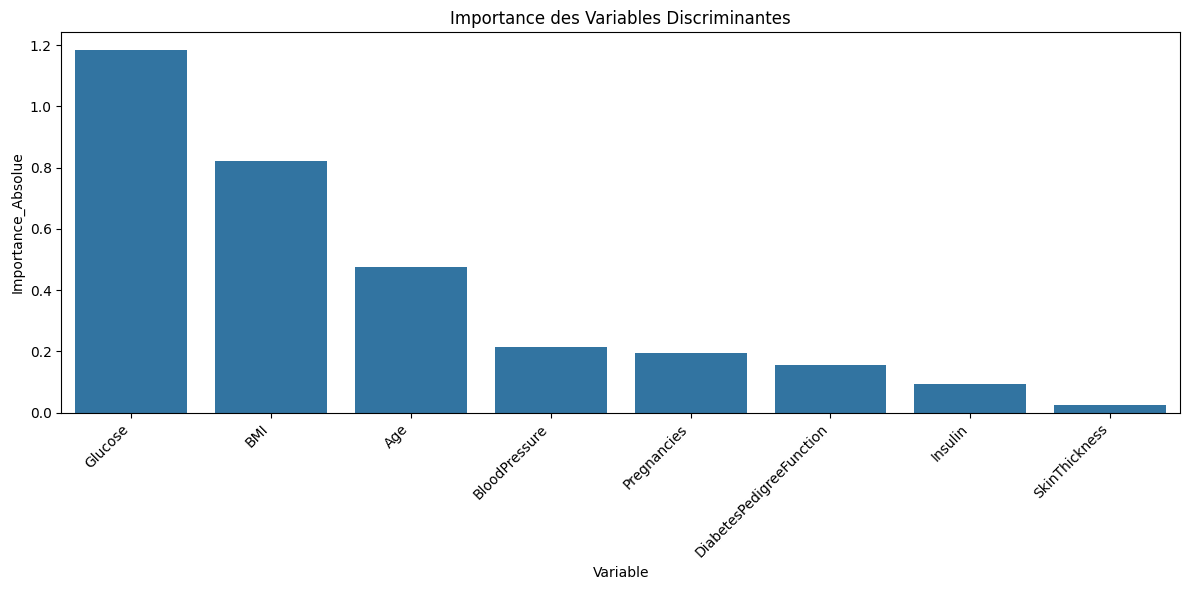

                   Variable  Coefficients  Importance_Absolue
1                   Glucose      1.182393            1.182393
5                       BMI      0.821313            0.821313
7                       Age      0.474518            0.474518
2             BloodPressure     -0.213328            0.213328
0               Pregnancies      0.195198            0.195198
6  DiabetesPedigreeFunction      0.155577            0.155577
4                   Insulin     -0.093898            0.093898
3             SkinThickness     -0.026017            0.026017


In [ ]:
variables_importantes = analyser.analyse_discriminant_variables()
print(variables_importantes)

### **Interpretation**
— `Le glucose` est de loin le facteur le plus discriminant <br>
— `L’IMC (BMI) et l’âge` sont les deuxième et troisième facteurs les plus impor-
tants <br>
— **L’épaisseur cutanée** a l’impact le plus faible sur la discrimination

### **Reduisons la dimensionnalité et visualisons**

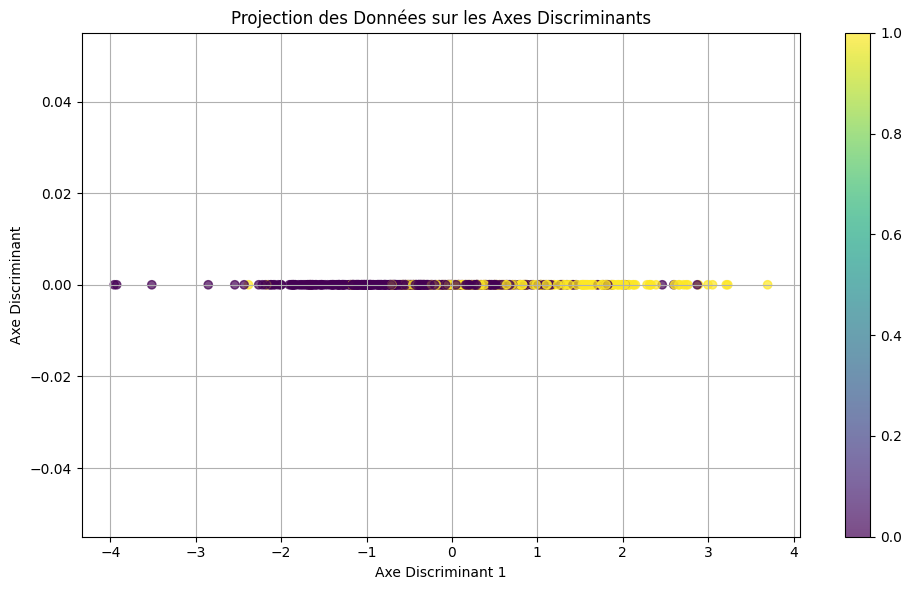

In [15]:
analyser.visualize_projection()

### Interpretation : <br>
Cette projection des donnees montre une séparation des classes sur l’axe discriminant
principal, avec un certain chevauchement entre les groupes diabétiques et non dia-
bétiques.

### **Evaluons le modele**

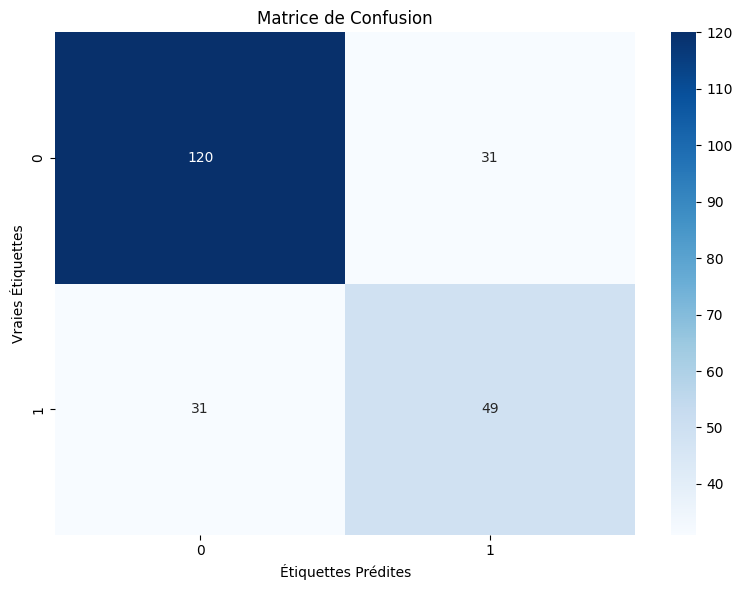


Accuracy: 0.7316017316017316

Matrice de Confusion:
[[120  31]
 [ 31  49]]

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       151
           1       0.61      0.61      0.61        80

    accuracy                           0.73       231
   macro avg       0.70      0.70      0.70       231
weighted avg       0.73      0.73      0.73       231



In [32]:
performance = analyser.evaluate_model()

### Interpretation du modele : <br>

Le modèle montre une meilleure performance pour identifier les cas négatifs (non
diabétiques) que les cas positifs (diabétiques), ce qui est reflété par une spécificité
plus élevée que la sensibilité.

### **Exemple de prédiction pour un nouveau patient**

In [27]:
new_sample = [ 6, 148, 72, 35, 0, 33.6, 0.627, 50 ]

prediction = analyser.predict_new_sample(new_sample)


print(f"===( La classe predite est : {prediction['classe_predite']}")
print(f"===( La probabilite que l'individu possede le diabete est : {prediction['probabilites'][1]}")
print(f"===( La probabilite que l'individu ne possede pas le diabete est : {prediction['probabilites'][0]} \n\n")

===( La classe predite est : 1
===( La probabilite que l'individu possede le diabete est : 0.7595892374590419
===( La probabilite que l'individu ne possede pas le diabete est : 0.24041076254095806 




/home/pharaon/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
